# Prepare SST dataset for comparison with CESM-LE

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import os
from glob import glob
import subprocess
import urllib
import calendar
from datetime import datetime
import tqdm

import numpy as np

import dask
import xarray as xr

import pop_tools

import util

In [23]:
clobber = False
dst_grid = 'POP_gx1v6'

FILE_OUT_ANN = f'{util.project_tmpdir}/woa2018_ANN.{dst_grid}.zarr'
FILE_OUT_DJF = f'{util.project_tmpdir}/woa2018_DJF.{dst_grid}.zarr'
FILE_OUT_DJF

'/glade/p/cgd/oce/projects/krill-cesm-le/data/woa2018_DJF.POP_gx1v6.zarr'

## Setup regridding machinery

Make SCRIP grid file for source grid.

In [24]:
gridfile_directory = f'{util.project_tmpdir}/regrid'
os.makedirs(gridfile_directory, exist_ok=True)

In [25]:
src_grid = 'latlon_1x1_lon180'
src_grid_file = f'{gridfile_directory}/{src_grid}.nc'

if not os.path.exists(src_grid_file) or clobber:
    dso = util.latlon_to_scrip(
        nx=360, 
        ny=180, 
        lon0=-180., 
        file_out=src_grid_file,
    )

Make SCRIP grid file for ocean model grid.

In [26]:
dst_grid_file= f'{gridfile_directory}/{dst_grid}.nc'

if not os.path.exists(dst_grid_file) or clobber:
    dso = pop_tools.get_grid('POP_gx1v6', scrip=True)
    del dso.attrs['region_mask_regions']
    print(f'writing {dst_grid_file}')
    dso.to_netcdf(dst_grid_file)

Call `ESMF_RegridWeightGen` to generate weight file.

In [27]:
%%time
method = 'conserve'
weight_file = f'{gridfile_directory}/{src_grid}_to_{dst_grid}_{method}.nc'

if not os.path.exists(weight_file) or clobber:
    cmd = ['ESMF_RegridWeightGen', '--netcdf4', '--ignore_unmapped',
                '-s', src_grid_file, '-d', dst_grid_file, '-m', method, '-w', weight_file]
    out = subprocess.run(cmd, capture_output=True, check=True)
    print(out.stdout.decode('UTF-8'))

CPU times: user 60 µs, sys: 0 ns, total: 60 µs
Wall time: 66 µs


Set up remapping operator

In [28]:
regrid_op = util.regridder(src_grid_file, dst_grid_file, weight_file)
regrid_op

source grid dims: (180, 360)
destination grid dims: (384, 320)


regridder latlon_1x1_lon180.nc --> POP_gx1v6.nc

## Download and process files

Set up some directories and xarray option for reading files.

In [29]:
dirloc = f'{util.project_tmpdir}/woa2018'
dirtmp = f'/glade/work/{os.environ["USER"]}/woa2018'
os.makedirs(dirloc, exist_ok=True)
os.makedirs(dirtmp, exist_ok=True)

Define a function for computing monthly means from daily files.

In [30]:
os.getcwd()

'/glade/u/home/mclong/p/krill-cesm-le/notebooks'

In [31]:

variables = dict(
    temperature=dict(
        sname='t',
        time_period='decav81B0',
    ),
    oxygen=dict(
        sname='o',
        time_period='all',
    )
)

    
def get_woa2018_data(varname, month_list, res='01'):
    """retrient WOA2018 data"""

    var_dict = variables[varname]
    sname = var_dict['sname']
    time_period = var_dict['time_period']
    baseurl = 'https://data.nodc.noaa.gov/thredds/fileServer/ncei/woa'
    
    filelist = []
    for avg in month_list:
        filename = f'woa18_{time_period}_{sname}{avg:02d}_{res}.nc'
        fullurl = f'{baseurl}/{varname}/{time_period}/1.00'
    
        f_local = f'{dirtmp}/{filename}'
        filelist.append(f_local)
        
        if not os.path.exists(f_local):
            print(f'downloading: {fullurl}/{filename}')            
            urllib.request.urlretrieve(f'{fullurl}/{filename}', f_local)
    
    return filelist

temp_files = get_woa2018_data('temperature', month_list=range(1, 13))
temp_files    

['/glade/work/mclong/woa2018/woa18_decav81B0_t01_01.nc',
 '/glade/work/mclong/woa2018/woa18_decav81B0_t02_01.nc',
 '/glade/work/mclong/woa2018/woa18_decav81B0_t03_01.nc',
 '/glade/work/mclong/woa2018/woa18_decav81B0_t04_01.nc',
 '/glade/work/mclong/woa2018/woa18_decav81B0_t05_01.nc',
 '/glade/work/mclong/woa2018/woa18_decav81B0_t06_01.nc',
 '/glade/work/mclong/woa2018/woa18_decav81B0_t07_01.nc',
 '/glade/work/mclong/woa2018/woa18_decav81B0_t08_01.nc',
 '/glade/work/mclong/woa2018/woa18_decav81B0_t09_01.nc',
 '/glade/work/mclong/woa2018/woa18_decav81B0_t10_01.nc',
 '/glade/work/mclong/woa2018/woa18_decav81B0_t11_01.nc',
 '/glade/work/mclong/woa2018/woa18_decav81B0_t12_01.nc']

In [32]:
ds = xr.open_mfdataset([temp_files[i] for i in [0, 1, 11]], combine='by_coords', decode_times=False).compute()
ds.isel(depth=slice(0, 3))

<xarray.Dataset>
Dimensions:             (depth: 3, lat: 180, lon: 360, nbounds: 2, time: 3)
Coordinates:
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * depth               (depth) float32 0.0 5.0 10.0
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time                (time) float64 168.5 169.5 179.5
Dimensions without coordinates: nbounds
Data variables:
    crs                 (time) int32 -2147483647 -2147483647 -2147483647
    lat_bnds            (time, lat, nbounds) float32 -90.0 -89.0 ... 89.0 90.0
    lon_bnds            (time, lon, nbounds) float32 -180.0 -179.0 ... 180.0
    depth_bnds          (time, depth, nbounds) float32 0.0 2.5 2.5 ... 7.5 12.5
    climatology_bounds  (time, nbounds) float32 0.0 349.0 1.0 350.0 11.0 360.0
    t_an                (time, depth, lat, lon) float32 nan nan ... -1.68831
    t_mn                (time, depth, lat, lon) float32 nan nan nan ... nan nan
    t_dd                (time, depth, lat, lon) float64 nan nan nan ... 0.0 0.0
    t_sd                (time, depth, lat, lon) float32 nan nan nan ... nan nan
    t_se                (time, depth, lat, lon) float32 nan nan nan ... nan nan
    t_oa                (time, depth, lat, lon) float32 nan nan nan ... nan nan
    t_ma                (time, depth, lat, lon) float32 nan nan ... 0.009899974
    t_gp                (time, depth, lat, lon) float64 nan nan ... 75.0 75.0
Attributes:
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    id:                              woa18_decav81B0_t01_01.nc
    naming_authority:                gov.noaa.ncei
    sea_name:                        World-Wide Distribution
    time_coverage_start:             1981-01-01
    time_coverage_end:               2010-01-31
    time_coverage_duration:          P30Y
    time_coverage_resolution:        P01M
    geospatial_lat_min:              -90.0
    geospatial_lat_max:              90.0
    geospatial_lon_min:              -180.0
    geospatial_lon_max:              180.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_max:         1500.0
    geospatial_lat_units:            degrees_north
    geospatial_lat_resolution:       1.00 degrees
    geospatial_lon_units:            degrees_east
    geospatial_lon_resolution:       1.00 degrees
    geospatial_vertical_units:       m
    geospatial_vertical_resolution:  SPECIAL
    geospatial_vertical_positive:    down
    creator_name:                    Ocean Climate Laboratory
    creator_email:                   NCEI.info@noaa.gov
    creator_url:                     http://www.ncei.noaa.gov
    creator_type:                    group
    creator_institution:             National Centers for Environmental Infor...
    project:                         World Ocean Atlas Project
    processing_level:                processed
    keywords:                        Oceans< Ocean Temperature > Water Temper...
    keywords_vocabulary:             ISO 19115
    standard_name_vocabulary:        CF Standard Name Table v49
    contributor_name:                Ocean Climate Laboratory
    contributor_role:                Calculation of climatologies
    cdm_data_type:                   Grid
    publisher_name:                  National Centers for Environmental Infor...
    publisher_institution:           National Centers for Environmental Infor...
    publisher_type:                  institution
    publisher_url:                   http://www.ncei.noaa.gov/
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version: 

In [33]:
%%time
ds = xr.open_mfdataset(temp_files, combine='by_coords', decode_times=False).compute()
with xr.set_options(keep_attrs=True):
    ds = ds.isel(depth=slice(0, 2)).mean(['depth', 'time']).expand_dims('time')
ds['sst'] = ds.t_an
ds = ds.rename(lat='nlat', lon='nlon')

ds = ds[['sst']]

ds_ann = pop_tools.get_grid('POP_gx1v6')[['TLAT', 'TLONG', 'KMT', 'TAREA']]
ds_ann.attrs = ds.attrs
ds_ann['sst'] = regrid_op.regrid_dataarray(
    ds.sst,
    renormalize=True, 
    apply_mask=True,
)
ds_ann

/glade/work/mclong/miniconda3/envs/krill/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 2.97 s, sys: 3.4 s, total: 6.37 s
Wall time: 12.4 s


<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 1)
Dimensions without coordinates: nlat, nlon, time
Data variables:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    KMT      (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    TAREA    (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    sst      (time, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    id:                              woa18_decav81B0_t01_01.nc
    naming_authority:                gov.noaa.ncei
    sea_name:                        World-Wide Distribution
    time_coverage_start:             1981-01-01
    time_coverage_end:               2010-01-31
    time_coverage_duration:          P30Y
    time_coverage_resolution:        P01M
    geospatial_lat_min:              -90.0
    geospatial_lat_max:              90.0
    geospatial_lon_min:              -180.0
    geospatial_lon_max:              180.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_max:         1500.0
    geospatial_lat_units:            degrees_north
    geospatial_lat_resolution:       1.00 degrees
    geospatial_lon_units:            degrees_east
    geospatial_lon_resolution:       1.00 degrees
    geospatial_vertical_units:       m
    geospatial_vertical_resolution:  SPECIAL
    geospatial_vertical_positive:    down
    creator_name:                    Ocean Climate Laboratory
    creator_email:                   NCEI.info@noaa.gov
    creator_url:                     http://www.ncei.noaa.gov
    creator_type:                    group
    creator_institution:             National Centers for Environmental Infor...
    project:                         World Ocean Atlas Project
    processing_level:                processed
    keywords:                        Oceans< Ocean Temperature > Water Temper...
    keywords_vocabulary:             ISO 19115
    standard_name_vocabulary:        CF Standard Name Table v49
    contributor_name:                Ocean Climate Laboratory
    contributor_role:                Calculation of climatologies
    cdm_data_type:                   Grid
    publisher_name:                  National Centers for Environmental Infor...
    publisher_institution:           National Centers for Environmental Infor...
    publisher_type:                  institution
    publisher_url:                   http://www.ncei.noaa.gov/
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-28 
    date_modified:                   2019-07-28

In [34]:
%%time
ds = xr.open_mfdataset([temp_files[i] for i in [0, 1, 11]], combine='by_coords', decode_times=False).compute()
with xr.set_options(keep_attrs=True):
    ds = ds.isel(depth=slice(0, 2)).mean(['depth', 'time']).expand_dims('time')
ds['sst'] = ds.t_an
ds = ds.rename(lat='nlat', lon='nlon')

ds = ds[['sst']]

ds_djf = pop_tools.get_grid('POP_gx1v6')[['TLAT', 'TLONG', 'KMT', 'TAREA']]
ds_djf.attrs = ds.attrs
ds_djf['sst'] = regrid_op.regrid_dataarray(
    ds.sst,
    renormalize=True, 
    apply_mask=True,
)
ds_djf

/glade/work/mclong/miniconda3/envs/krill/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 919 ms, sys: 776 ms, total: 1.69 s
Wall time: 1.79 s


<xarray.Dataset>
Dimensions:  (nlat: 384, nlon: 320, time: 1)
Dimensions without coordinates: nlat, nlon, time
Data variables:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    KMT      (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    TAREA    (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.431e+12 7.432e+12
    sst      (time, nlat, nlon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         Climatological mean temperature for the ...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    id:                              woa18_decav81B0_t01_01.nc
    naming_authority:                gov.noaa.ncei
    sea_name:                        World-Wide Distribution
    time_coverage_start:             1981-01-01
    time_coverage_end:               2010-01-31
    time_coverage_duration:          P30Y
    time_coverage_resolution:        P01M
    geospatial_lat_min:              -90.0
    geospatial_lat_max:              90.0
    geospatial_lon_min:              -180.0
    geospatial_lon_max:              180.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_max:         1500.0
    geospatial_lat_units:            degrees_north
    geospatial_lat_resolution:       1.00 degrees
    geospatial_lon_units:            degrees_east
    geospatial_lon_resolution:       1.00 degrees
    geospatial_vertical_units:       m
    geospatial_vertical_resolution:  SPECIAL
    geospatial_vertical_positive:    down
    creator_name:                    Ocean Climate Laboratory
    creator_email:                   NCEI.info@noaa.gov
    creator_url:                     http://www.ncei.noaa.gov
    creator_type:                    group
    creator_institution:             National Centers for Environmental Infor...
    project:                         World Ocean Atlas Project
    processing_level:                processed
    keywords:                        Oceans< Ocean Temperature > Water Temper...
    keywords_vocabulary:             ISO 19115
    standard_name_vocabulary:        CF Standard Name Table v49
    contributor_name:                Ocean Climate Laboratory
    contributor_role:                Calculation of climatologies
    cdm_data_type:                   Grid
    publisher_name:                  National Centers for Environmental Infor...
    publisher_institution:           National Centers for Environmental Infor...
    publisher_type:                  institution
    publisher_url:                   http://www.ncei.noaa.gov/
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-28 
    date_modified:                   2019-07-28

In [35]:
util.write_ds_out(ds_djf, FILE_OUT_DJF)
util.write_ds_out(ds_djf, FILE_OUT_ANN)

------------------------------
Writing /glade/p/cgd/oce/projects/krill-cesm-le/data/woa2018_DJF.POP_gx1v6.zarr
xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 320 ;
	time = 1 ;

variables:
	float64 TLAT(nlat, nlon) ;
		TLAT:units = degrees_north ;
		TLAT:long_name = T-grid latitude ;
	float64 TLONG(nlat, nlon) ;
		TLONG:units = degrees_east ;
		TLONG:long_name = T-grid longitude ;
	int32 KMT(nlat, nlon) ;
		KMT:long_name = k Index of Deepest Grid Cell on T Grid ;
		KMT:coordinates = TLONG TLAT ;
	float64 TAREA(nlat, nlon) ;
		TAREA:units = cm^2 ;
		TAREA:long_name = area of T cells ;
		TAREA:coordinates = TLONG TLAT ;
	float64 sst(time, nlat, nlon) ;
		sst:standard_name = sea_water_temperature ;
		sst:long_name = Objectively analyzed mean fields for sea_water_temperature at standard depth levels. ;
		sst:cell_methods = area: mean depth: mean time: mean within years time: mean over years ;
		sst:grid_mapping = crs ;
		sst:units = degrees_celsius ;

// global attributes:
	:Conventions

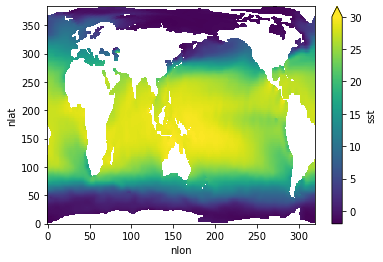

In [36]:
ds_djf.sst.mean('time').plot(vmin=-2, vmax=30)

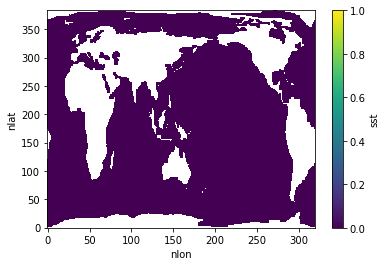

In [37]:
ds_djf.sst.std('time').plot(vmin=0, vmax=1)